## Preparation
Make the file structure:

In [1]:
import os, shutil

base_dir = 'data_small'

def rm_dir(my_dir):
    if os.path.exists(my_dir):
        shutil.rmtree(my_dir)

rm_dir(base_dir)

def make_dir(my_dir):
    if not os.path.exists(my_dir):
        os.mkdir(my_dir)

make_dir(base_dir)

def sub_dir(base_dir, sub_dir):
    sub_dir = os.path.join(base_dir, sub_dir)
    make_dir(sub_dir)
    return sub_dir

train_dir = sub_dir(base_dir, 'train')
train_x_dir = sub_dir(train_dir, 'x')
train_y_dir = sub_dir(train_dir, 'y')

val_dir = sub_dir(base_dir, 'val')
val_x_dir = sub_dir(val_dir, 'x')
val_y_dir = sub_dir(val_dir, 'y')

test_dir = sub_dir(base_dir, 'test')

Copy over some images. Our x's are images, while our y's are labels:

In [2]:
import random

total_size = 1000
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1
train_size = int(total_size * train_ratio)
val_size = int(total_size * val_ratio)
test_size = int(total_size * test_ratio)

file_names = random.sample(os.listdir('data/training/images'), train_size)

def clear_dir(my_dir):
    file_names = os.listdir(my_dir)
    
    for file_name in file_names:
        os.remove(os.path.join(my_dir, file_name))

def copy_files(src_dir, dest_dir, file_names):
    for file_name in file_names:
        shutil.copy(os.path.join(src_dir, file_name), dest_dir)

clear_dir(train_x_dir)
copy_files('data/training/images', train_x_dir, file_names)

def set_ext(file_name, ext):
    return os.path.splitext(file_name)[0] + ext

clear_dir(train_y_dir)
copy_files('data/training/v2.0/labels', train_y_dir, list(map(lambda x : set_ext(x, '.png'), file_names)))

file_names = random.sample(os.listdir('data/validation/images'), val_size)
clear_dir(val_x_dir)
copy_files('data/validation/images', val_x_dir, file_names)
clear_dir(val_y_dir)
copy_files('data/validation/v2.0/labels', val_y_dir, list(map(lambda x : set_ext(x, '.png'), file_names)))

file_names = random.sample(os.listdir('data/testing/images'), test_size)
clear_dir(test_dir)
copy_files('data/testing/images', test_dir, file_names)

What does an input and its label look like? Let's convert them into tensors and display them:

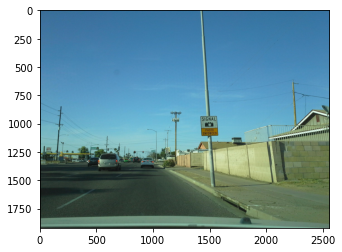

img.shape: (1920, 2560, 3)


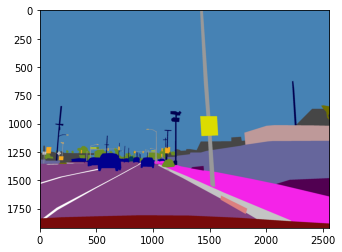

label.shape: (1920, 2560, 3)


In [3]:
from keras import utils
import matplotlib.pyplot as plt

file_name = os.listdir(train_x_dir)[0]
img = utils.load_img(os.path.join(train_x_dir, file_name))
img = utils.img_to_array(img)
img /= 255

plt.imshow(img)
plt.show()
print('img.shape: ' + str(img.shape))

file_name = os.listdir(train_y_dir)[0]
label = utils.load_img(os.path.join(train_y_dir, file_name))
label = utils.img_to_array(label)
label /= 255
plt.imshow(label)
plt.show()
print('label.shape: ' + str(label.shape))

Enumerating the categories produces arbitrary values, while one-hot encoding (one matrix per category) is high-dimensional and sparse. For this reason we'll train an autoencoder to learn its own encodings:

In [16]:
from keras import models
from keras import layers
from keras import optimizers

input_width = 256
input_height = 256
input_shape = (input_width, input_height, 3)

encoder = models.Sequential()
encoder.add(layers.Conv2D(4, kernel_size=3, padding='same', activation='selu', input_shape=(input_shape)))
encoder.add(layers.MaxPool2D(pool_size=2))
encoder.add(layers.Conv2D(8, kernel_size=3, padding='same', activation='selu'))
encoder.add(layers.MaxPool2D(pool_size=2))

decoder = models.Sequential()
decoder.add(layers.Conv2DTranspose(4, kernel_size=3, strides=2, padding='same', activation='selu', input_shape=(64, 64, 8)))
decoder.add(layers.Conv2DTranspose(3, kernel_size=3, strides=2, padding='same', activation='softmax'))
decoder.add(layers.Reshape(input_shape))

autoencoder = models.Sequential([encoder, decoder])
autoencoder.compile(loss='binary_crossentropy', optimizer=optimizers.Adam())
autoencoder.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 64, 64, 8)         408       
                                                                 
 sequential_4 (Sequential)   (None, 256, 256, 3)       403       
                                                                 
Total params: 811
Trainable params: 811
Non-trainable params: 0
_________________________________________________________________


Let's start training:

In [17]:
batch_size = 20
num_epochs = 16
normalizer = layers.Rescaling(1./255)

def get_gen(x_dir, y_dir):
    x_dataset = utils.image_dataset_from_directory(
        x_dir,
        labels=None,
        batch_size=batch_size,
        image_size=(input_height, input_width),
        shuffle=False
    )
    
    x_dataset = x_dataset.map(lambda x: normalizer(x))
    x_dataset = x_dataset.repeat()
    
    y_dataset = utils.image_dataset_from_directory(
        y_dir,
        labels=None,
        batch_size=batch_size,
        image_size=(input_height, input_width),
        shuffle=False
    ).repeat()
    
    y_dataset = y_dataset.map(lambda x: normalizer(x))
    y_dataset = y_dataset.repeat()
    
    return zip(x_dataset, y_dataset)

train_gen = get_gen(train_x_dir, train_y_dir)
val_gen = get_gen(val_x_dir, val_y_dir)

history = autoencoder.fit(
    train_gen,
    steps_per_epoch=train_size//batch_size,
    epochs=num_epochs,
    validation_data=val_gen,
    validation_steps=val_size//batch_size
)

Found 800 files belonging to 1 classes.
Found 800 files belonging to 1 classes.
Found 100 files belonging to 1 classes.
Found 100 files belonging to 1 classes.
Epoch 1/16
40/40 [==============================] - 14s 287ms/step - loss: 0.7064 - val_loss: 0.7051
Epoch 2/16
40/40 [==============================] - 12s 302ms/step - loss: 0.7010 - val_loss: 0.6995
Epoch 3/16
40/40 [==============================] - 12s 310ms/step - loss: 0.6956 - val_loss: 0.6941
Epoch 4/16
40/40 [==============================] - 13s 322ms/step - loss: 0.6925 - val_loss: 0.6925
Epoch 5/16
40/40 [==============================] - 12s 296ms/step - loss: 0.6916 - val_loss: 0.6918
Epoch 6/16
40/40 [==============================] - 13s 340ms/step - loss: 0.6908 - val_loss: 0.6910
Epoch 7/16
40/40 [==============================] - 15s 373ms/step - loss: 0.6898 - val_loss: 0.6897
Epoch 8/16
40/40 [==============================] - 17s 430ms/step - loss: 0.6883 - val_loss: 0.6883
Epoch 9/16
40/40 [==============

What does a prediction look like?

Found 100 files belonging to 1 classes.
5/5 [==============================] - 1s 120ms/step


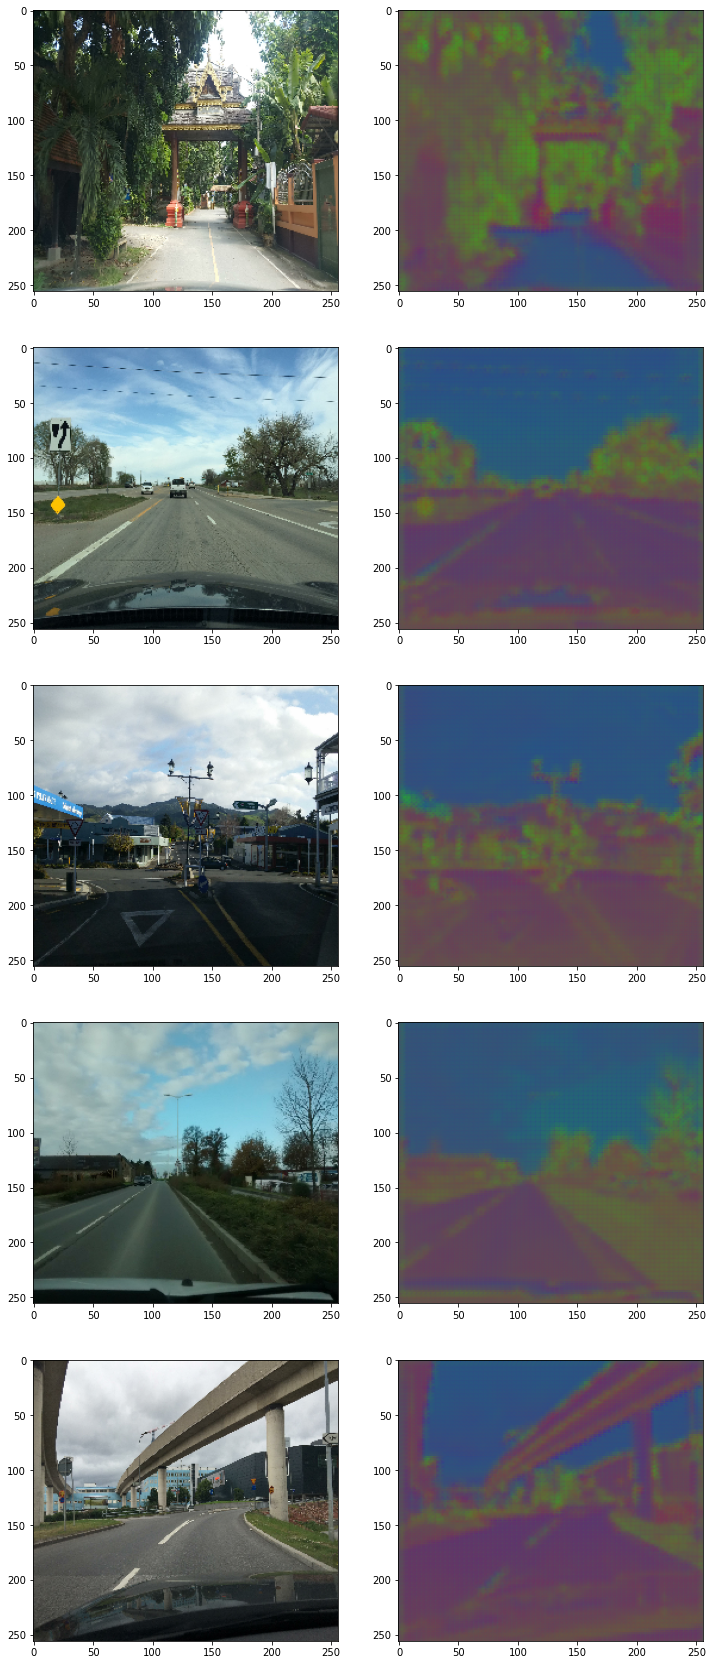

In [49]:
import matplotlib.pyplot as plt

test_gen = utils.image_dataset_from_directory(
    test_dir,
    labels=None,
    batch_size=batch_size,
    image_size=(input_height, input_width),
    shuffle=False
)

test_gen = test_gen.map(lambda x: normalizer(x))
predictions = autoencoder.predict(test_gen)
dataset = test_gen.take(1)
figure, axes = plt.subplots(5, 2, figsize=(12, 30))
indices = random.sample(range(batch_size), 5)

for data in dataset:
    for i in range(5):
        axes[i][0].imshow(data[indices[i]])
        axes[i][0].set_aspect('auto')
        axes[i][1].imshow(predictions[indices[i]])
        axes[i][1].set_aspect('auto')

# plt.subplots_adjust(wspace=0, hspace=0.5)
plt.show()